# 2.0 — Pré-traitement & Features (SPX, SPY, VIX)

**Explication :**
1) Définit les dossiers de travail (RAW_DIR & OUT_DIR)
2) Déclare des variables universelles, donc le mapping des variables SPX_INDEX, SPY_ETF, VIX_INDEX
3) Définit quelque constantes financières : 
    - TRADING_DAYS : approximation du nombre de jours de bourse par an
    - EWM_LAMBDA : paramètre de la méthode RiskMetrics (moyenne exponentielle pondérée pour la volatilité)

**Pourquoi nous avons fait cela :** 
1) Séparer RAW_DIR et OUT_DIR assure une traçabilité claire entre données brutes et données transformées.
2) Permet de gérer facilement plusieurs actifs en nommant explicitement chacun (Lisibilité augmenté)

In [23]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RAW_DIR = Path("data/raw")
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

UNIVERSE = {
    "SPX_INDEX": RAW_DIR / "spx_index.parquet",
    "SPY_ETF":   RAW_DIR / "spy_etf.parquet",
    "VIX_INDEX": RAW_DIR / "vix_index.parquet",
}
TRADING_DAYS = 252
EWM_LAMBDA = 0.94  


## 2.1 Fonction load_df — lecture & normalisation d’un dataset

**Explication :**
1) Vérifie que la colonne "date" est bien présente (sinon lève une erreur)
2) Normalise les noms de colonnes (minuscule, snake_case).
3) Trie les données par date, supprime les doublons, et réinitialise l’index.
4) Sélectionne uniquement les colonnes utiles si elles existent. 

**Pourquoi nous avons fait cela :**
1) Forcer la présence d’une date garantit que le dataset est bien une série temporelle
2) Normaliser les colonnes évite les problèmes de casse/espaces.
3) Trier et supprimer les doublons assure une série chronologique propre et unique.
4) Ne garder que les colonnes clés réduit le bruit et garantit une structure standardisée pour les traitements suivants.


In [24]:
def load_df(path: Path) -> pd.DataFrame:
    df = pd.read_parquet(path) if path.suffix == ".parquet" else pd.read_csv(path, parse_dates=["date"])
    if "date" not in df.columns:
        raise ValueError(f"{path} n'a pas de colonne 'date'")
    df.columns = [c.lower().strip().replace(" ", "_") for c in df.columns]
    df = df.sort_values("date").drop_duplicates(subset=["date"]).reset_index(drop=True)
    keep = ["date","open","high","low","close","adj_close","volume"]
    cols = [c for c in keep if c in df.columns]
    return df[cols]


## 2.2 Utilitaires de pré-traitement

**Explication :**
1) La fonction "clamp_series" tronque une série en bornant ses valeurs entre deux quantiles (lo_q et hi_q) pour limiter l’influence des valeurs extrêmes.
2) La fonction "realized_vol_std" calcule la volatilité réalisée avec un écart-type glissant (non biaisé, annualisé avec √252).
3) La fonction "realized_vol_ewm" calcule la volatilité réalisée via un schéma Exponentially Weighted Moving (méthode RiskMetrics)
4) La fonction "parkinson_vol" calcule la volatilité selon l’estimateur de Parkinson (1980) basé sur le range (High/Low), souvent plus efficace que l’écart-type si les données H/L sont propres.

**Pourquoi nous avons fait cela:**
1) clamp_series → Réduit l’impact des outliers sur les indicateurs de volatilité, pour des mesures plus stables.
2) realized_vol_std → Fournit une mesure simple et standard de la volatilité historique (référence de base).
3) realized_vol_ewm → Intègre la mémoire dégressive du marché (les chocs récents influencent davantage la volatilité).
4) parkinson_vol → Utilise toute l’information intrajournalière (High/Low) → estimateur plus efficace statistiquement que la simple variance des rendements.



In [25]:
def clamp_series(s: pd.Series, lo_q=0.001, hi_q=0.999):
    lo, hi = s.quantile(lo_q), s.quantile(hi_q)
    return s.clip(lower=lo, upper=hi)

def realized_vol_std(ret: pd.Series, win: int) -> pd.Series:
    return ret.rolling(win, min_periods=win).std(ddof=1) * np.sqrt(TRADING_DAYS)

def realized_vol_ewm(ret: pd.Series, lam: float) -> pd.Series:
    alpha = 1 - lam
    var_ewm = ret.pow(2).ewm(alpha=alpha, adjust=False).mean()
    return np.sqrt(var_ewm * TRADING_DAYS)

def parkinson_vol(high: pd.Series, low: pd.Series, win: int) -> pd.Series:
    if not set(["high","low"]).issubset(set(high.index.names) | set(low.index.names)):
        pass
    rng = (high/low).apply(np.log)**2
    k = 1.0 / (4.0 * np.log(2.0))
    return (k * rng.rolling(win, min_periods=win).mean())**0.5 * np.sqrt(TRADING_DAYS)


## 2.3 Fonction make_features — construction des variables de marché
 
**Explication :**
1) Calcule les rendements logarithmiques journaliers (ret_d).
2) Applique un clamp sur les rendements (ret_d_clamped) pour réduire l’impact des outliers.
3) Calcule différentes volatilités réalisées :
    - vol21 / vol63 : écart-type glissant annualisé sur 21 et 63 jours.
    - vol_ewm_094 : volatilité exponentielle pondérée (RiskMetrics, λ=0.94).
    - vol_pk21 / vol_pk63 : volatilité de Parkinson sur 21 et 63 jours (si colonnes High/Low disponibles).
4) Supprime les lignes incomplètes, réinitialise l’index.
5) Ajoute une colonne asset pour identifier la série.

**Pourquoi nous avons fait cela:**
1) Utiliser les rendements log est plus adapté pour l’addition dans le temps et la modélisation.
2) Clamping des outliers → stabilise les modèles sensibles (LSTM, GARCH)
3) Multiplier les mesures de volatilité → capture différentes dynamiques de risque (fenêtres courtes vs longues).
4) Nettoyage final → évite les biais ou erreurs dans l’entraînement des modèles.
5) Ajout de asset → facilite l’agrégation multi-actifs et la traçabilité.



In [26]:
def make_features(df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = df.copy()

    if "adj_close" not in out.columns and "close" in out.columns:
        out["adj_close"] = out["close"]

    out["ret_d"] = np.log(out["adj_close"] / out["adj_close"].shift(1))

    out["ret_d_clamped"] = clamp_series(out["ret_d"])

    out["vol21"] = realized_vol_std(out["ret_d_clamped"], 21)
    out["vol63"] = realized_vol_std(out["ret_d_clamped"], 63)

    out["vol_ewm_094"] = realized_vol_ewm(out["ret_d_clamped"], EWM_LAMBDA)

    if {"high","low"}.issubset(out.columns):
        out["vol_pk21"] = parkinson_vol(out["high"], out["low"], 21)
        out["vol_pk63"] = parkinson_vol(out["high"], out["low"], 63)

    out = out.dropna().reset_index(drop=True)
    out["asset"] = name
    return out


## 2.4 Fonction align_on_common_days — alignement des séries temporelles

**Explication :**
1) Calcule l’intersection des dates présentes dans toutes les séries
2) Trie cette liste de dates communes pour garantir l’ordre chronologique
3) Pour chaque DataFrame, conserve uniquement les lignes correspondant à ces dates.
4) Retourne un dictionnaire de DataFrames alignés, chacun limité aux jours communs.

**Pourquoi nous avons fait cela:**
1) L’intersection des dates évite les comparaisons biaisées (ex : un actif a des jours fériés ou trous de données que les autres n’ont pas).
2) Trier les dates garantit une série temporelle utilisable pour les modèles et graphiques.
3) Aligner tous les actifs sur le même calendrier permet des comparaisons cohérentes et des agrégations fiables.
4) La sortie en dictionnaire conserve la structure d’entrée et facilite la réutilisation dans les étapes suivantes.


In [27]:
def align_on_common_days(dfs: dict[str, pd.DataFrame]) -> dict[str, pd.DataFrame]:
    common = None
    for d in dfs.values():
        dates = set(pd.to_datetime(d["date"]).dt.normalize())
        common = dates if common is None else (common & dates)
    common = pd.Index(sorted(list(common)))
    out = {}
    for k, d in dfs.items():
        dd = d[d["date"].dt.normalize().isin(common)].copy().reset_index(drop=True)
        out[k] = dd
    return out


## 2.5 Fonction main — pipeline de prétraitement de bout en bout

**Explication :**
1) Charge chaque dataset de UNIVERSE avec load_df, puis construit les features avec make_features; stocke le tout dans datas.
2) Aligne toutes les séries sur les mêmes jours de bourse via align_on_common_days
3) Prépare des métadonnées
    - features
    - trading_days
    - ewm_lambda
4) Sauvegarde les features par actif en CSV & Parquet.
5) Concatène tous les actifs en un panel unique (panel_features.*) pour les analyses multi-actifs.

**Pourquoi nous avons fait cela:**
1) Chaîne claire load → features par actif → facilite le debug et l’extension
2) L’alignement calendaires évite les biais de comparaison (jours manquants, fériés) et garantit des métriques cohérentes.
3) Les métadonnées documentent les hypothèses (252 jours, λ=0.94) pour la traçabilité.
4) Sauvegarder par actif + un panel global couvre à la fois les besoins unitaires et les analyses transverses.
5) Double format (CSV + Parquet) = interopérabilité + performance.


In [28]:
def main():
    datas = {}
    for name, path in UNIVERSE.items():
        df = load_df(path)
        feats = make_features(df, name)
        datas[name] = feats

    datas = align_on_common_days(datas)

    meta = {"features": [
        "ret_d","ret_d_clamped","vol21","vol63","vol_ewm_094","vol_pk21","vol_pk63"
    ], "trading_days": TRADING_DAYS, "ewm_lambda": EWM_LAMBDA}

    panel = []
    for name, feats in datas.items():
        out_csv = OUT_DIR / f"{name.lower()}_features.csv"
        out_par = OUT_DIR / f"{name.lower()}_features.parquet"
        feats.to_csv(out_csv, index=False)
        feats.to_parquet(out_par, index=False)
        panel.append(feats.assign(asset=name))

    panel = pd.concat(panel, axis=0, ignore_index=True)
    panel.to_parquet(OUT_DIR / "panel_features.parquet", index=False)
    panel.to_csv(OUT_DIR / "panel_features.csv", index=False)

    (OUT_DIR / "features_meta.json").write_text(json.dumps(meta, indent=2), encoding="utf-8")
    print("✅ Pré-traitement terminé →", OUT_DIR.resolve())


In [29]:
if __name__ == "__main__":
    main()


✅ Pré-traitement terminé → C:\Users\antoi\Proton Drive\antoinebuisson000\My files\12 - SKEMA\4 - CARRIERE FINANCE\1 - PROJET FINANCE QUANT\notebook\data\processed


### 2.6 Inspection des données prétraitées — vérification des sorties

**Explication :**
1) Liste et affiche tous les fichiers présents dans data/processed pour vérifier que le prétraitement a bien généré les sorties attendues.
2) Charge le fichier panel_features.parquet qui contient toutes les features concaténées pour l’univers d’actifs.
3) Affiche un aperçu des premières lignes avec head() pour contrôler la structure et les colonnes.
4) Compte le nombre d’observations par actif (asset) pour vérifier l’équilibre et la cohérence des séries.


In [30]:
from pathlib import Path
import pandas as pd

print("Fichiers écrits :", sorted([p.name for p in Path("data/processed").glob("*")]))

panel = pd.read_parquet("data/processed/panel_features.parquet")
display(panel.head())
panel["asset"].value_counts()


Fichiers écrits : ['features_meta.json', 'panel_features.csv', 'panel_features.parquet', 'spx_index_features.csv', 'spx_index_features.parquet', 'spy_etf_features.csv', 'spy_etf_features.parquet', 'vix_index_features.csv', 'vix_index_features.parquet']


,date,open,high,low,close,adj_close,volume,ret_d,ret_d_clamped,vol21,vol63,vol_ewm_094,vol_pk21,vol_pk63,asset
0,1993-04-30,438.890015,442.290009,438.890015,440.190002,440.190002,247460000,0.002958,0.002958,0.111039,0.113384,0.101822,0.092462,0.093356,SPX_INDEX
1,1993-05-03,440.190002,442.589996,438.250000,442.459991,442.459991,224970000,0.005144,0.005144,0.112957,0.112567,0.100726,0.093671,0.093550,SPX_INDEX
2,1993-05-04,442.579987,445.190002,442.450012,444.049988,444.049988,268310000,0.003587,0.003587,0.089735,0.112796,0.098649,0.083318,0.093668,SPX_INDEX
3,1993-05-05,443.980011,446.089996,443.760010,444.519989,444.519989,274240000,0.001058,0.001058,0.089558,0.110823,0.095732,0.083549,0.092984,SPX_INDEX
4,1993-05-06,444.600006,444.809998,442.899994,443.260010,443.260010,255460000,-0.002838,-0.002838,0.089673,0.110415,0.093469,0.081992,0.092855,SPX_INDEX


asset
SPX_INDEX    8152
SPY_ETF      8152
VIX_INDEX    8152
Name: count, dtype: int64

### 2.7 Affichage des graphiques 

**Graphique 1:**
- On observe une distribution centrée autour de 0, avec des pics extrêmes, par exemple la crise des subprimes en 2008 ou la crise du COVID-19 en 2020.
- Comme attendu, les rendements présentent une forte hétéroscédasticité : périodes calmes vs périodes de chocs violents.
- Cela justifie l’utilisation de modèles conditionnels de variance comme GARCH/EGARCH.

**Graphique 2:**
- Elle reflète bien les pics de volatilité en 2000 (bulle Internet), 2008 (crise Lehman), 2020 (COVID).
- On voit une persistance de la volatilité : quand elle monte, elle reste élevée plusieurs semaines/mois
- Confirme que la volatilité n’est pas constante (contrairement à l’hypothèse de Black–Scholes)

**Graphique 3:**
- Le VIX suit globalement la même dynamique que la vol réalisée, mais souvent avec des pics plus élevés, cela reflète la prime de risque intégrée dans la volatilité implicite.
- Montre que le VIX est une bonne variable explicative/feature pour enrichir les modèles

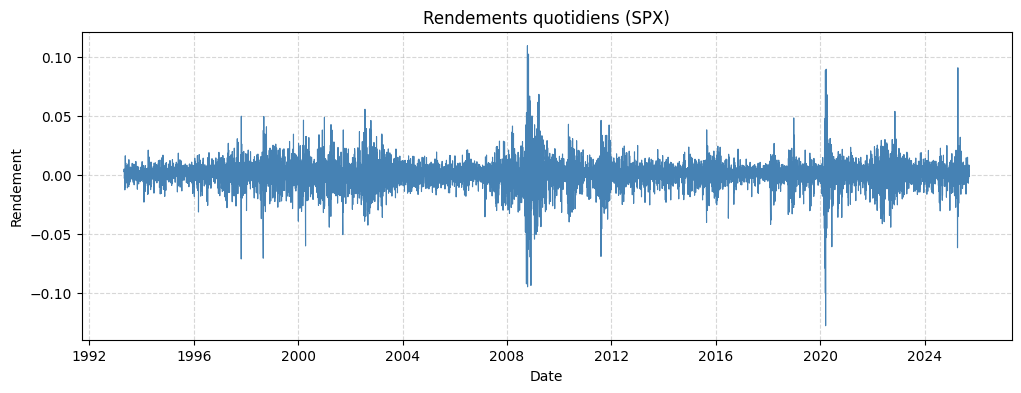

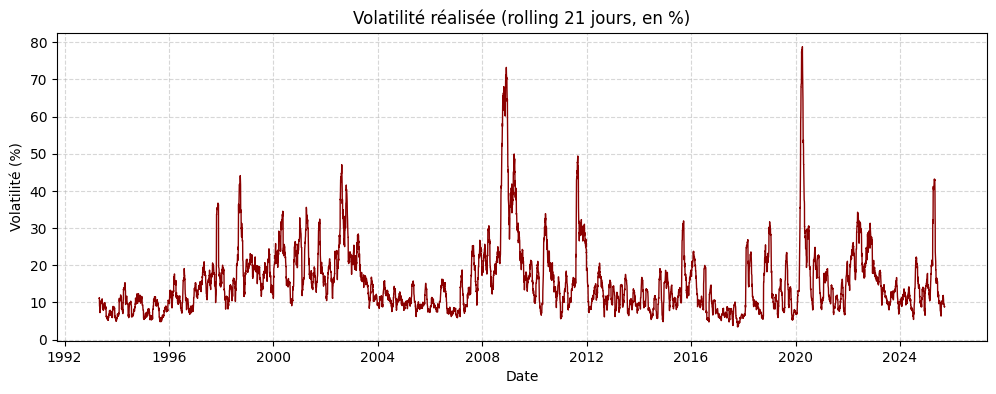

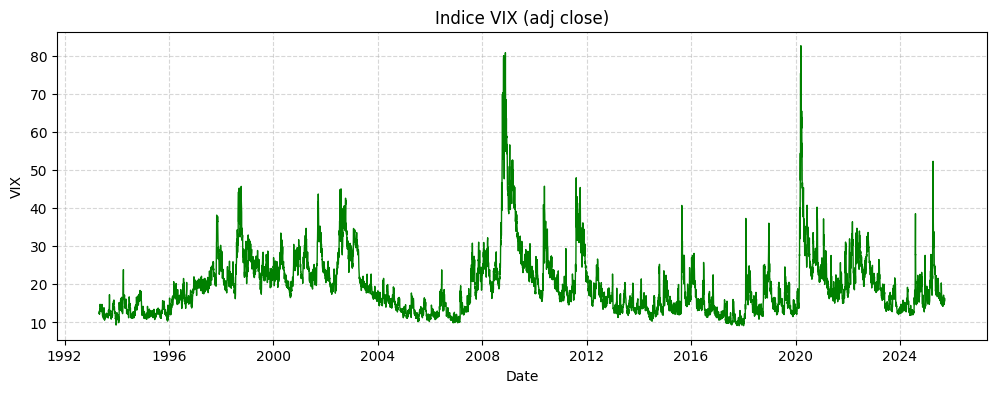

: 

In [ ]:


PROC_DIR = Path("data/processed")

# Charger SPX features
df = pd.read_parquet(PROC_DIR / "spx_index_features.parquet")

# Vérifier type date
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])

# === Graphique 1 : Rendements quotidiens ===
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['ret_d'], color='steelblue', lw=0.8)
plt.title("Rendements quotidiens (SPX)")
plt.xlabel("Date")
plt.ylabel("Rendement")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# === Graphique 2 : Volatilité réalisée (21 jours) ===
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['vol21']*100, color='darkred', lw=1.0)
plt.title("Volatilité réalisée (rolling 21 jours, en %)")
plt.xlabel("Date")
plt.ylabel("Volatilité (%)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# === Graphique 3 : Indice VIX ===
try:
    vix = pd.read_parquet(PROC_DIR / "vix_index_features.parquet")
    if not pd.api.types.is_datetime64_any_dtype(vix['date']):
        vix['date'] = pd.to_datetime(vix['date'])
    plt.figure(figsize=(12,4))
    plt.plot(vix['date'], vix['adj_close'], color='green', lw=1.0)
    plt.title("Indice VIX (adj close)")
    plt.xlabel("Date")
    plt.ylabel("VIX")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
except Exception as e:
    print("⚠️ Impossible de tracer le VIX :", e)
